# Survival Analysis
This notebook demonstrates some of the scikit survival analysis features and makes some comparisons between survival analysis and machine learning classification algorithms.

**Note:** Be sure you've read my notes both on survival analysis and classifier performance metrics before working through this notebook.

    Copyright (C) 2021 Geoffrey Guy Messier

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import numpy as np
import pandas as pd
import datetime, copy, imp
import time
import matplotlib.pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn import metrics

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV

from tqdm.auto import tqdm, trange
from tqdm.notebook import tqdm
tqdm.pandas()

import sys
sys.path.insert(0, '../util/')

ModuleNotFoundError: No module named 'sksurv'

### Load Data

In [3]:
dataFileStr = '../data/MLBHospitalData.hdf'
dat = pd.read_hdf(dataFileStr,key='Features')

FileNotFoundError: File ../data/MLBHospitalData.hdf does not exist

### Input Data Features (Covariates)

The input data features to survival analysis tend to be counts of a number of events that have occured in a particular time window (ie. number of emergency room visits) or the characteristic of an individual at a particular point in time (ie. age, weight, etc.).  These input features are known as *covariates*.  The time window used to determine the covariantes is referred to as the observation window.

In [4]:
# Count events for an individual in an observation window from startDate to endDate.
def calculate_covariates(tbl,startDate='NoDate',endDate='NoDate'):
    if startDate != 'NoDate' and endDate != 'NoDate':
        tbl = tbl.loc[ (tbl.Date >= startDate) & (tbl.Date <= endDate) ]
        
    if len(tbl.index) == 0:
        return pd.Series({
            'NumGoodTestResult': 0,
            'NumStay': 0,
            'NumBadTestResult': 0,
            'NumVitalsCrash': 0,
            'Tenure': 0
        })        
    else:
        return pd.Series({
            'NumGoodTestResult': (tbl.Event == 'GoodTestResult').sum(),
            'NumStay': (tbl.Event == 'Stay').sum(),
            'NumBadTestResult': (tbl.Event == 'BadTestResult').sum(),
            'NumVitalsCrash': (tbl.Event == 'VitalsCrash').sum(),
            'Tenure': (tbl.Date.max()-tbl.Date.min()).days
        })

In [5]:
# Observation inteval.
obsStart = pd.to_datetime('2016-01-01')
obsEnd = pd.to_datetime('2017-12-31')

inFtr = dat.groupby(level=0).progress_apply(calculate_covariates,startDate=obsStart,endDate=obsEnd)

  0%|          | 0/915 [00:00<?, ?it/s]

### Time to Event

Survival analysis will select an event (ie. death from heart failure, diagnosis of a disease) and determine whether it occurs for each individual during a *follow-up period*.  If the event occurs, the time to the event (TTE) is recorded.  If it does not occur, we say that the data record is *right censored* and we record the time of censoring (the end time of the follow-up period).

For this notebook, we will use the first occurence of an AdverseOutcome as our event of interest.

In [6]:
def find_adverse_outcome(tbl,startDate,endDate):
    advOutIdx = (tbl.Event == 'VitalsCrash') & (tbl.Date >= startDate) & (tbl.Date <= endDate)
    if advOutIdx.sum() > 0:
        return pd.Series({
            'Flag': 'Crash',
            'Time': (tbl.loc[advOutIdx].Date.min() - startDate).days
        })
    else:
        return pd.Series({
            'Flag': 'NoCrash',
            'Time': max(0,(endDate - startDate).days)
        })

In [7]:
# Follow up interval.
followStart = pd.to_datetime('2018-01-01')
followEnd = pd.to_datetime('2019-12-31')

tte = dat.groupby(level=0).progress_apply(find_adverse_outcome,startDate=followStart,endDate=followEnd)

  0%|          | 0/915 [00:00<?, ?it/s]

### Survival Function

Fitting an approximation to the survival or hazard functions calculated from real data is the foundation of surival analysis theory.  While we don't have to calculate it in order to use a Cox model, it's instructive to have a look at it.  Note that it does not go to zero since many individuals "survive" our follow up interval. 

Text(0.5, 0, 'Days')

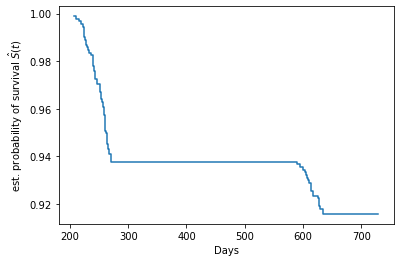

In [8]:
time, survival_prob = kaplan_meier_estimator((tte.Flag == 'Adverse'), tte.Time)
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("Days")

### Cox Regression

Like many linear methods, Cox regression works best if the data features are normalized to have zero mean and unit variance.

In [9]:
inFtrNrm = copy.deepcopy(inFtr)
for colInd in inFtr.columns:
    inFtrNrm[colInd] = (inFtr[colInd]-inFtr[colInd].mean())/np.sqrt(inFtr[colInd].var())

In [11]:
# The scikit routine requires this strange numpy array format.
datY = np.array([ (tte.loc[ind,'Flag'] == 'Crash', tte.loc[ind,'Time']) for ind in inFtr.index ],
                dtype = [ ('Flag','?'), ('Time','f')])

In [12]:
cox = CoxPHSurvivalAnalysis()

In [13]:
cox.fit(inFtrNrm,datY)

CoxPHSurvivalAnalysis()

Like most linear methods, the coefficients produced by CoxPH indicates the influence a data features has over the event of interest.  In the following, we see that `NumGoodTestResult` is the most influential data feature and (as expected) is negatively correlated with the event of interest.

In [14]:
for i in range(len(cox.coef_)):
    print('{}: {:.3f}'.format(inFtrNrm.columns[i],cox.coef_[i]))

NumReferral: -1.390
NumStay: 0.209
NumMajorEvent: 0.502
NumAdverseOutcome: 0.289
Tenure: -0.108


The scikit documentation states that the predict routine returns a "risk score".  The documentation is a bit vague but this score is equal to the $\beta x$ term in the CoxPH hazard function equation.  If these values are positive, the chance of the event increases and, if they're negative, the chance decreases.

In [15]:
riskScores = cox.predict(inFtrNrm)

Text(0.5, 0, 'Risk Score')

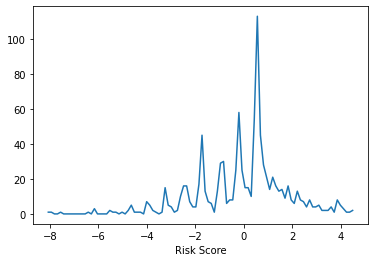

In [16]:
[h,bins] = np.histogram(riskScores,bins=100)
plt.plot(bins[:-1],h)
plt.xlabel('Risk Score')

Once the Cox coefficients, $\beta$, are determined, a risk score can be calculated for an individual and applied to a threshold.  If the score exceeds the threshold, then we assume that the event will occur.  Changing the threshold will change the performance of these decisions.  A very low threshold will assume all individuals are positive (100% false positive and 100% false negative rate) and a very high threshold will assume that all individuals are negative (0% false positive and 0% false negative rate).  

Adjusting the threshold between those two extremes will result in different false positive and false negative rates.  This can be traced on a receiver operating characteristic (ROC) curve.

In [17]:
pfp, ptp, thresholds = metrics.roc_curve(datY['Flag'], riskScores)

Text(0, 0.5, 'P(true positive)')

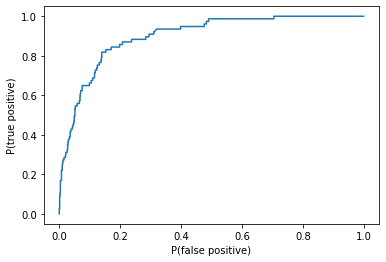

In [18]:
plt.plot(pfp,ptp)
plt.xlabel('P(false positive)')
plt.ylabel('P(true positive)')

Ideally, our classifier would have a 0% false positive rate and 100% true positive rate so that the ROC curve reaches the upper left hand corner of the plot.  The area under this ideal curve would be 1.  A non-ideal curve does not reach the upper left hand corner and has an area $<1$.  As a result, area under the ROC curve is sometimes used as a performance metric.  The C-index is one way to estimate this area.

In [19]:
print('C-Index: ',concordance_index_censored(datY['Flag'], datY['Time'], riskScores)[0])

C-Index:  0.8878374369623258
